# Avance 3. Baseline

## Proyecto Integrador - MNA

### Equipo 21

Integrantes del equipo:
- Guadalupe Esmeralda González Maldonado - A01795767
- Marco Daniel Cameros Bobadilla - A01795655
- Jesús Armando Anaya Orozco - A01795464

Nombre del dataset: DDR2019

## Contexto y objetivo de este notebook

Este notebook presenta un baseline para clasificación de retinopatía diabética a partir de imágenes de fondo de ojo.

Un baseline es la primera solución razonable y reproducible. Sirve como punto de comparación para decidir si conviene seguir iterando sobre el problema con evidencia.

En esta entrega se usa como enfoque principal **DenseNet-121** como extractor de características y **XGBoost** como clasificador. Se busca una solución práctica, estable y fácil de interpretar en tiempo de cómputo razonable.

### Qué se busca demostrar con este baseline

- **Elección del modelo**: usamos embeddings de un modelo preentrenado y XGBoost para tener una solución reproducible y con costo de cómputo razonable, sin perder capacidad de clasificación.
- **Qué señales está usando**: con XGBoost podemos inspeccionar qué partes del embedding influyen más en la decisión, lo que ayuda a entender si el modelo está aprovechando información útil.
- **Si generaliza o solo memoriza**: revisamos el desempeño en validación y el comportamiento por clase para detectar brechas claras entre lo que aprende y lo que realmente predice fuera del entrenamiento.
- **Cómo medimos desempeño**: damos prioridad a métricas que no escondan el desbalance (por ejemplo, F1-macro), y dejamos accuracy como referencia secundaria.
- **Qué tan aceptable es el resultado**: comparamos contra un punto de referencia ingenuo (predecir siempre la clase mayoritaria) para confirmar que el modelo aporta valor por encima de lo mínimo.

### Referencia de inspiración

La selección del baseline se guía por literatura reciente en detección de retinopatía diabética, en particular el trabajo descrito en *Enhanced Detection of Diabetic Retinopathy Through Transfer Learning with DenseNet-121 and XGBoost Classifier*.

Además, también revisamos y contrastamos los enfoques descritos en *Identification of Diabetic Retinopathy Using Weighted Fusion Deep Learning Based on Dual-Channel Fundus Scans*, *Diabetic retinopathy identification using parallel convolutional neural network based feature extractor and ELM classifier* y *Analysis of Early Detection and Prediction of Diabetic Retinopathy by Optimize Deep Learning with XG-Boosting* (todos incluidos en la bibliografía de este notebook). La intención fue intentar reproducir, de forma práctica, lo reportado en estas publicaciones utilizando PyTorch y modelos base open source (por ejemplo: VGG-16, InceptionV3, ResNet-50 y DenseNet-121), manteniendo un flujo reproducible y consistente con nuestras limitaciones de cómputo.

Hasta este punto, el enfoque que hemos logrado reproducir con resultados aceptables para esta entrega es el que se documenta en este notebook. Para entregas posteriores, continuaremos trabajando en variantes adicionales basadas en los otros artículos, con el objetivo de ampliar la comparación entre enfoques y fortalecer la validez del baseline propuesto.


## 1) Setup del proyecto y dependencias

Esta sección define entorno, rutas y librerías para asegurar reproducibilidad. Es muy importante que la ejecución sea consistente entre corridas para comparar resultados de forma justa.


In [1]:
import os
import random
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from PIL import Image
import torch.nn as nn
from scipy.stats import randint, uniform
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer

from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.models import DenseNet121_Weights
from torchvision.transforms import functional as TF
from torchvision.transforms.functional import InterpolationMode
from tqdm.auto import tqdm
from xgboost import XGBClassifier

from sam_ml.datasets import DDR2019Dataset
from sam_ml.preprocessing.filters import apply_clahe_bgr


In [2]:
# Resolver la raíz del proyecto de forma robusta.
_path = Path.cwd()
while _path != _path.parent and not (_path / "pyproject.toml").exists():
    _path = _path.parent
PROJECT_ROOT = _path if (_path / "pyproject.toml").exists() else Path.cwd()
os.chdir(PROJECT_ROOT)

# Fijar semillas para reproducibilidad.
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Dataset base para la baseline (baseline).
DATA_DIR = PROJECT_ROOT / "data" / "processed" / "ddr2019"
LABELS_CSV = DATA_DIR / "labels.csv"

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_DIR (baseline): {DATA_DIR}")
print(f"labels.csv existe: {LABELS_CSV.exists()}")


PROJECT_ROOT: /home/anaya/Development/Robomous/sam-ai
DATA_DIR (baseline): /home/anaya/Development/Robomous/sam-ai/data/processed/ddr2019
labels.csv existe: True


In [3]:
# Cargar dataset base (una sola imagen por muestra) y validar contrato de salida.
base_dataset_train = DDR2019Dataset(
    data_dir=DATA_DIR,
    split="train",
    train_ratio=0.75,
    val_ratio=0.25,
    transform=transforms.ToTensor(),
    random_state=SEED,
)

base_dataset_all = DDR2019Dataset(
    data_dir=DATA_DIR,
    split="all",
    transform=transforms.ToTensor(),
    random_state=SEED,
)

image_sample, label_sample = base_dataset_train[0]

print(f"Muestras train: {len(base_dataset_train)}")
print(f"Muestras all: {len(base_dataset_all)}")
print(f"Shape imagen: {tuple(image_sample.shape)}")
print(f"Label de ejemplo: {label_sample}")


Muestras train: 9389
Muestras all: 12522
Shape imagen: (3, 512, 512)
Label de ejemplo: 0


## 2) Configuración de preprocesamiento para el baseline

Se usa la normalización esperada por el modelo preentrenado para reducir desajustes entre la distribución de entrada y los pesos aprendidos en ImageNet.

En términos simples, el "input size esperado" es el tamaño de imagen para el que la red fue entrenada originalmente. Mantener ese tamaño y esa normalización ayuda a sostener un comportamiento estable.


In [4]:
# Definir pesos de referencia para el baseline.
densenet_weights = DenseNet121_Weights.DEFAULT
densenet_preset = densenet_weights.transforms()

densenet_norm_mean = torch.tensor(densenet_preset.mean, dtype=torch.float32)
densenet_norm_std = torch.tensor(densenet_preset.std, dtype=torch.float32)

print("Normalización del baseline (DenseNet-121):")
print(f"  input_size esperado: {densenet_preset.crop_size[0]} x {densenet_preset.crop_size[0]}")
print(f"  mean: {densenet_norm_mean.tolist()}")
print(f"  std: {densenet_norm_std.tolist()}")


Normalización del baseline (DenseNet-121):
  input_size esperado: 224 x 224
  mean: [0.48500001430511475, 0.4560000002384186, 0.4059999883174896]
  std: [0.2290000021457672, 0.2240000069141388, 0.22499999403953552]


## 3) Transformaciones de normalización del baseline

Se aplica normalización compatible con DenseNet-121 usando estadísticas de ImageNet.

Estas transformaciones preparan la imagen para que el backbone "vea" los datos en condiciones similares a su preentrenamiento. Eso reduce el riesgo de degradación por cambio de escala o distribución.

In [5]:
def normalize_with_stats_torch(x: torch.Tensor, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
    """Normalizar tensor RGB con media/desviación esperadas por un backbone."""
    m = mean.view(3, 1, 1).to(x.device, x.dtype)
    s = std.view(3, 1, 1).to(x.device, x.dtype).clamp_min(1e-8)
    return (x - m) / s


def denormalize_with_stats_torch(x: torch.Tensor, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
    """Deshacer normalización RGB para visualización."""
    m = mean.view(3, 1, 1).to(x.device, x.dtype)
    s = std.view(3, 1, 1).to(x.device, x.dtype)
    return x * s + m


def preprocess_image_for_densenet(x: torch.Tensor) -> torch.Tensor:
    """Preprocesar imagen para baseline con DenseNet-121."""
    x = x.float().clamp(0.0, 1.0)
    return normalize_with_stats_torch(x, densenet_norm_mean, densenet_norm_std)


## 4) Balanceo de clases

En retinopatía diabética existe desbalance de clases y esto impacta directamente la calidad del aprendizaje. Si se entrena sin control, el modelo tiende a optimizar para clases frecuentes y puede degradar el recall en clases con menos ejemplos.

### Decisión metodológica usada en este notebook

1. Primero se **fusionan 5 clases en 3** (`0`, `1+2`, `3+4`) para reducir ambigüedad entre severidades adyacentes.
2. Después se construye un **set de entrenamiento balanceado real** (el que entra al modelo), en lugar de reportar distribuciones parciales.
3. Se usa augmentación geométrica controlada (`original + hflip + vflip + 1 rotación`) y downsampling en mayoritarias cuando corresponde.

### Justificación de por qué se hace así

- **Evitar sesgo de frecuencia**: una clase con muchos más ejemplos domina la función objetivo.
- **Evitar sobre-augmentación sin criterio**: aumentar clases de manera desproporcionada puede volver a desbalancear el train.
- **Mantener factibilidad de cómputo**: se usa un objetivo alcanzable con los 4 modos de augmentación disponibles.

Conexión con rúbrica: este bloque justifica por qué **macro-F1** y **macro-recall** son métricas prioritarias. En escenarios desbalanceados, accuracy puede verse alta y aun así ocultar mal desempeño en clases menos frecuentes.

**Costo/beneficio**: balancear mejora cobertura por clase y estabilidad del entrenamiento, pero incrementa costo de cómputo por el número de muestras transformadas.

In [6]:
train_rows = base_dataset_train._rows.reset_index(drop=True).copy()

class_counts = train_rows["label"].value_counts().sort_index()
mean_count = class_counts.mean()
minority_threshold = mean_count * 0.5
minority_classes = set(class_counts[class_counts < minority_threshold].index.tolist())

AUGMENTATION_MULTIPLIER = 4
MAJORITY_CAP = 3500

augmentation_targets: dict[int, dict[str, float]] = {}
for label, count in class_counts.items():
    is_minority = int(label) in minority_classes
    target_count = int(count) * AUGMENTATION_MULTIPLIER if is_minority else int(count)
    augmentation_targets[int(label)] = {
        "current_count": int(count),
        "target_count": int(target_count),
        "multiplier": AUGMENTATION_MULTIPLIER if is_minority else 1,
        "is_minority": is_minority,
    }

downsampling_ratios: dict[int, dict[str, float]] = {}
for label, count in class_counts.items():
    is_majority = float(count) > float(mean_count)
    if is_majority and int(count) > MAJORITY_CAP:
        new_count = MAJORITY_CAP
        reduction_pct = (1.0 - (new_count / int(count))) * 100.0
    else:
        new_count = int(count)
        reduction_pct = 0.0
    downsampling_ratios[int(label)] = {
        "current_count": int(count),
        "new_count": int(new_count),
        "reduction_pct": float(reduction_pct),
        "is_downsampled": bool(is_majority and int(count) > MAJORITY_CAP),
    }

final_counts: dict[int, int] = {}
for label in sorted(class_counts.index.tolist()):
    if int(label) in minority_classes:
        final_counts[int(label)] = int(augmentation_targets[int(label)]["target_count"])
    else:
        final_counts[int(label)] = int(downsampling_ratios[int(label)]["new_count"])

original_imbalance_ratio = float(class_counts.max() / class_counts.min())
final_counts_series = pd.Series(final_counts).sort_index()
final_imbalance_ratio = float(final_counts_series.max() / final_counts_series.min())

print("Resumen de balanceo (baseline):")
print(f"  class_counts: {class_counts.to_dict()}")
print(f"  mean_count: {mean_count:.2f}")
print(f"  minority_threshold (50% mean): {minority_threshold:.2f}")
print(f"  minority_classes: {sorted(list(minority_classes))}")
print(f"  AUGMENTATION_MULTIPLIER: {AUGMENTATION_MULTIPLIER}")
print(f"  MAJORITY_CAP: {MAJORITY_CAP}")
print(f"  ratio original: {original_imbalance_ratio:.2f}:1")
print(f"  ratio final: {final_imbalance_ratio:.2f}:1")


Resumen de balanceo (baseline):
  class_counts: {0: 4699, 1: 472, 2: 3357, 3: 177, 4: 684}
  mean_count: 1877.80
  minority_threshold (50% mean): 938.90
  minority_classes: [1, 3, 4]
  AUGMENTATION_MULTIPLIER: 4
  MAJORITY_CAP: 3500
  ratio original: 26.55:1
  ratio final: 4.94:1


## 5) Utilidades de balanceo y augmentación

Estas utilidades concentran la lógica de muestreo por clase y de augmentación geométrica reproducible.

La idea es mantener reglas consistentes de balanceo para aumentar exposición de clases minoritarias y reducir dominancia de clases mayoritarias, sin alterar el flujo principal del baseline.


In [7]:
def _sample_indices_per_class(
    rows: pd.DataFrame,
    majority_cap: int,
    seed: int,
) -> list[int]:
    """Aplicar downsampling por clase para mayoritarias y mantener el resto."""
    rng = np.random.default_rng(seed)
    selected: list[int] = []

    counts = rows["label"].value_counts().sort_index()
    mean_count_local = counts.mean()

    for label in sorted(counts.index.tolist()):
        cls_rows = rows[rows["label"] == label]
        cls_indices = cls_rows.index.to_numpy()
        is_majority = counts[label] > mean_count_local

        if is_majority and len(cls_indices) > majority_cap:
            chosen = rng.choice(cls_indices, size=majority_cap, replace=False)
            selected.extend(chosen.tolist())
        else:
            selected.extend(cls_indices.tolist())

    return selected


def _build_augmented_sample_list(
    rows: pd.DataFrame,
    selected_indices: list[int],
    minority_set: set[int],
) -> list[tuple[int, int]]:
    """Construir lista (base_index, aug_id) según clase minoritaria/no minoritaria."""
    samples: list[tuple[int, int]] = []
    for idx in selected_indices:
        label = int(rows.loc[idx, "label"])
        if label in minority_set:
            # 0 = original, 1 = hflip, 2 = vflip, 3 = rot
            for aug_id in (0, 1, 2, 3):
                samples.append((int(idx), int(aug_id)))
        else:
            samples.append((int(idx), 0))
    return samples


def _draw_rotation_angles(rng: np.random.Generator) -> tuple[float, float]:
    """Generar dos ángulos distintos con magnitud en [10,15]."""

    def _one_angle() -> float:
        mag = float(rng.uniform(10.0, 15.0))
        sign = -1.0 if rng.random() < 0.5 else 1.0
        return sign * mag

    angle1 = _one_angle()
    angle2 = _one_angle()
    while abs(angle2 - angle1) < 1e-6:
        angle2 = _one_angle()
    return angle1, angle2



## 6) Verificación inicial del pipeline

Este bloque valida integridad básica del flujo antes de entrenar:

- formato y dimensiones esperadas de tensores,
- etiquetas en rango válido,
- consistencia entre tamaño del batch y contenido.

Esta verificación es muy importante para detectar errores tempranos de datos y evitar diagnósticos confusos durante el entrenamiento.


In [8]:
# Verificación rápida del dataset base (baseline).
batch_size = 8
baseline_loader = DataLoader(
    base_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

images_batch, labels_batch = next(iter(baseline_loader))

print("Sanity check:")
print(f"  images_batch shape: {tuple(images_batch.shape)}")
print(f"  labels_batch shape: {tuple(labels_batch.shape)}")
print(f"  rango imágenes: [{float(images_batch.min()):.3f}, {float(images_batch.max()):.3f}]")


Sanity check:
  images_batch shape: (8, 3, 512, 512)
  labels_batch shape: (8,)
  rango imágenes: [0.000, 1.000]


=== Resumen de pipeline ===
DATA_DIR: /home/anaya/Development/Robomous/sam-ai/data/processed/ddr2019
Split train base: 9389
Split all base: 12522
images_batch shape: (8, 3, 512, 512)
labels_batch shape: (8,)
Distribución original (train): {0: 4699, 1: 472, 2: 3357, 3: 177, 4: 684}
Distribución final objetivo: {0: 3500, 1: 1888, 2: 3357, 3: 708, 4: 2736}
Ratio original: 26.55:1
Ratio final: 4.94:1


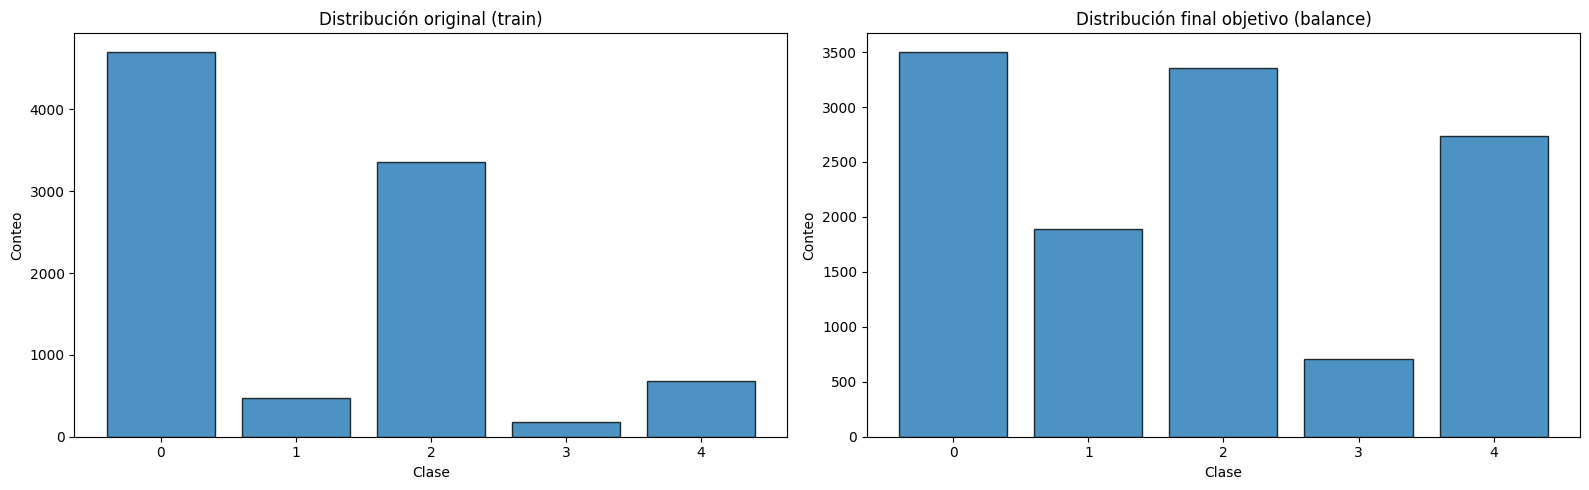

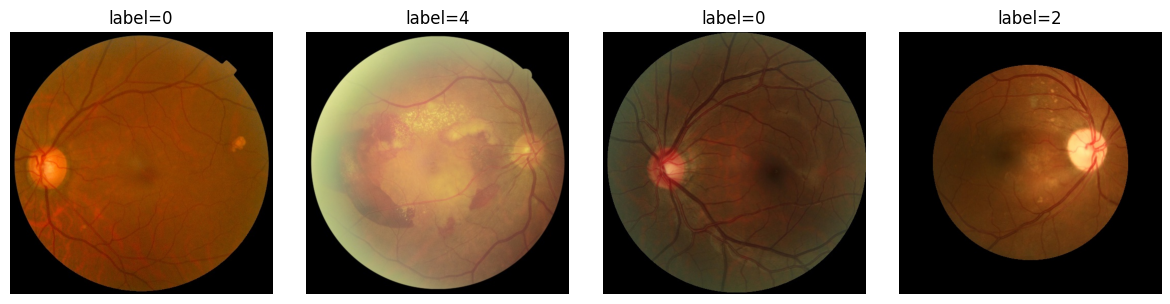

In [9]:
print("=== Resumen de pipeline ===")
print(f"DATA_DIR: {DATA_DIR}")
print(f"Split train base: {len(base_dataset_train)}")
print(f"Split all base: {len(base_dataset_all)}")
print(f"images_batch shape: {tuple(images_batch.shape)}")
print(f"labels_batch shape: {tuple(labels_batch.shape)}")
print(f"Distribución original (train): {class_counts.to_dict()}")
print(f"Distribución final objetivo: {final_counts_series.to_dict()}")
print(f"Ratio original: {original_imbalance_ratio:.2f}:1")
print(f"Ratio final: {final_imbalance_ratio:.2f}:1")

# Graficar distribución original vs final objetivo.
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

classes_sorted = sorted(class_counts.index.tolist())
x = np.arange(len(classes_sorted))
orig_values = [int(class_counts.loc[c]) for c in classes_sorted]
final_values = [int(final_counts_series.loc[c]) for c in classes_sorted]

axes[0].bar(x, orig_values, edgecolor="black", alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(classes_sorted)
axes[0].set_title("Distribución original (train)")
axes[0].set_xlabel("Clase")
axes[0].set_ylabel("Conteo")

axes[1].bar(x, final_values, edgecolor="black", alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(classes_sorted)
axes[1].set_title("Distribución final objetivo (balance)")
axes[1].set_xlabel("Clase")
axes[1].set_ylabel("Conteo")

plt.tight_layout()
plt.show()

# Mostrar muestras del batch de la baseline.
n_show = min(4, images_batch.shape[0])
fig, axes = plt.subplots(1, n_show, figsize=(3 * n_show, 3))
if n_show == 1:
    axes = np.array([axes])

for i in range(n_show):
    image_vis = images_batch[i].detach().cpu().clamp(0.0, 1.0)
    axes[i].imshow(np.transpose(image_vis.numpy(), (1, 2, 0)))
    axes[i].set_title(f"label={int(labels_batch[i])}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

Después de aplicar aumento de datos en las cinco clases, observamos que algunas categorías siguen quedando muy desbalanceadas. Intentamos entrenar el modelo respetando esas proporciones, pero los resultados no fueron favorables. Por ello, decidimos aplicar un ajuste adicional de ingeniería de características: combinar las clases 1 y 2, y también las clases 3 y 4. Esto, derivado de la naturaleza de las clases y considerando lo que consideramos, podría impactar de forma menos negativa a los resultados.

## 7) Baseline (DenseNet-121 + XGBoost)

### ¿Por qué usamos este baseline?
Porque es una forma práctica de clasificar imágenes con costo de cómputo controlado y resultados reproducibles:

- **DenseNet-121 (preentrenado)** se usa para convertir cada imagen en un vector de números que resume su contenido visual.
- **XGBoost** toma ese vector y aprende a predecir la clase. Además, es rápido de entrenar y permite revisar qué señales influyen más.

### ¿Qué significa "características" aquí?
En este enfoque, las características son los datos de entrada para XGBoost. Principalmente son:

- **Embeddings** (el vector que genera DenseNet-121 por imagen).
- **características globales simples** calculadas sobre la imagen como apoyo.

### ¿Cómo sabemos qué señales está usando el modelo?
XGBoost permite estimar importancia de características, lo que ayuda a identificar qué partes del vector pesan más en la decisión y a detectar si el modelo se está apoyando demasiado en pocas señales.

### Desempeño mínimo esperado
El modelo debe superar un punto de referencia muy simple, predecir siempre la clase mayoritaria.

Si no lo supera, lo más probable es que el problema esté en la señal de los datos o en el flujo de preprocesamiento, y conviene ajustar eso antes de hacer el modelo más complejo.


### Ajuste metodológico previo al feature engineering

Antes de extraer características se realizan ajustes deliberados al conjunto de datos para que el entrenamiento sea más estable, más fácil de interpretar y mejor alineado al riesgo clínico.

- Reducción de 5 a 3 clases: se agrupan etiquetas cercanas (`0, 1+2, 3+4`) para disminuir ambigüedad entre grados adyacentes y reducir ruido en las fronteras de decisión.
- Criterio clínico explícito: en este contexto conviene minimizar falsos negativos en casos de mayor severidad; por eso, cuando hay duda, se prefiere un sesgo conservador hacia categorías de mayor riesgo.
- Balanceo con objetivo verificable: se define un `target_count_per_class` realista y se valida con los conteos finales mostrados (`final_train_counts` y `final_train_proportions`).
- Augmentación controlada: se aplican transformaciones geométricas simples (`hflip`, `vflip`, `rotación`) para mejorar robustez sin modificar la semántica clínica de la imagen.
- CLAHE consistente en `train/val`: se aplica el mismo criterio de preprocesamiento en entrenamiento y validación para evitar cambios de distribución.

Muy importante: la distribución mostrada en esta sección corresponde al dataset final que entra al modelo, no a una etapa intermedia.

In [10]:
def _imagenet_stats_from_densenet() -> tuple[list[float], list[float]]:
    weights = DenseNet121_Weights.DEFAULT
    mean = list(weights.meta.get("mean", (0.485, 0.456, 0.406)))
    std = list(weights.meta.get("std", (0.229, 0.224, 0.225)))
    return mean, std


def _to_gray(x: torch.Tensor) -> torch.Tensor:
    """Convertir RGB->grayscale (tensor CHW en [0,1])."""
    r, g, b = x[0], x[1], x[2]
    return (0.2989 * r + 0.5870 * g + 0.1140 * b).clamp(0.0, 1.0)


def _global_features(x: torch.Tensor, hist_bins: int = 16) -> torch.Tensor:
    """Features globales: mean/std por canal + histograma en escala de grises."""
    ch_mean = x.mean(dim=(1, 2))
    ch_std = x.std(dim=(1, 2), unbiased=False)

    gray = _to_gray(x)
    hist = torch.histc(gray, bins=int(hist_bins), min=0.0, max=1.0)
    hist = hist / (hist.sum().clamp_min(1.0))

    return torch.cat([ch_mean, ch_std, hist], dim=0).float()


def _apply_geometry(
    image: torch.Tensor,
    aug_id: int,
    idx: int,
    seed: int,
) -> torch.Tensor:
    """Aplicar augmentación geométrica simple (reproducible por índice)."""
    if int(aug_id) == 0:
        return image
    if int(aug_id) == 1:
        return TF.hflip(image)
    if int(aug_id) == 2:
        return TF.vflip(image)

    rng = np.random.default_rng(int(seed) + int(idx))
    mag = float(rng.uniform(10.0, 15.0))
    sign = -1.0 if rng.random() < 0.5 else 1.0
    angle = sign * mag

    return TF.rotate(
        image,
        angle=float(angle),
        interpolation=InterpolationMode.BILINEAR,
        fill=0.0,
    )


LABEL_MAP_5_TO_3: dict[int, int] = {0: 0, 1: 1, 2: 1, 3: 2, 4: 2}


class MappedLabelDataset(Dataset):
    """Wrap a base dataset and remap labels while preserving _rows support."""

    def __init__(self, base_dataset: DDR2019Dataset, label_map: dict[int, int]) -> None:
        self.base_dataset = base_dataset
        self.label_map = dict(label_map)
        self._rows = self.base_dataset._rows.copy()
        self._rows["label"] = self._rows["label"].map(self.label_map).astype(int)

    def __len__(self) -> int:
        return len(self.base_dataset)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        image, label = self.base_dataset[int(idx)]
        return image, int(self.label_map[int(label)])


class ClahePILTransform:
    """Apply CLAHE in BGR space and return a PIL RGB image."""

    def __call__(self, image: Image.Image) -> Image.Image:
        rgb = np.asarray(image.convert("RGB"), dtype=np.uint8)
        bgr = np.ascontiguousarray(rgb[..., ::-1])
        bgr_clahe = apply_clahe_bgr(bgr)
        rgb_clahe = np.ascontiguousarray(bgr_clahe[..., ::-1])
        return Image.fromarray(rgb_clahe)


class BaselineSingleFeatureDataset(Dataset):
    """Dataset para baseline (ddr2019): imagen procesada para DenseNet + features globales extra."""

    def __init__(
        self,
        base_dataset: "DDR2019Dataset",
        samples: list[tuple[int, int]],
        seed: int,
        image_size: int = 224,
        hist_bins: int = 16,
    ) -> None:
        self.base_dataset = base_dataset
        self.samples = list(samples)
        self.seed = int(seed)
        self.image_size = int(image_size)
        self.hist_bins = int(hist_bins)

        self.mean, self.std = _imagenet_stats_from_densenet()

    def __len__(self) -> int:
        return len(self.samples)

    def _prep_for_densenet(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # Redimensionar a 224x224 (para features globales consistentes) antes de normalizar.
        x = TF.resize(
            x,
            [self.image_size, self.image_size],
            interpolation=InterpolationMode.BILINEAR,
            antialias=True,
        )
        x = x.float().clamp(0.0, 1.0)

        extra = _global_features(x, hist_bins=self.hist_bins)
        x_norm = TF.normalize(x, mean=self.mean, std=self.std)
        return x_norm, extra

    def __getitem__(self, item_idx: int) -> dict[str, torch.Tensor]:
        base_index, aug_id = self.samples[int(item_idx)]
        image, label = self.base_dataset[int(base_index)]
        image = image.float().clamp(0.0, 1.0)

        image_aug = _apply_geometry(
            image,
            aug_id=int(aug_id),
            idx=int(base_index),
            seed=self.seed,
        )

        image_in, extra = self._prep_for_densenet(image_aug)

        return {
            "image": image_in,
            "extra": extra,
            "label": torch.tensor(int(label), dtype=torch.long),
        }


# DenseNet-121 como extractor de características.
def build_densenet121_feature_extractor() -> nn.Module:
    """DenseNet-121 preentrenado como extractor: salida (B, 1024)."""
    model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
    model.classifier = nn.Identity()

    # Congelar parámetros: solo extracción.
    for p in model.parameters():
        p.requires_grad = False

    return model

# Extraer features de DenseNet-121 para el baseline
@torch.no_grad()
def extract_baseline_features(
    feature_model: nn.Module,
    loader: DataLoader,
    device: torch.device,
) -> tuple[np.ndarray, np.ndarray]:
    """Extraer features concatenadas (DenseNet + extras)."""
    feature_model = feature_model.to(device)
    feature_model.eval()

    feats: list[np.ndarray] = []
    labels: list[np.ndarray] = []

    for batch in tqdm(loader, desc="Extrayendo features (DenseNet)", total=len(loader)):
        image = batch["image"].to(device, non_blocking=True)
        extra = batch["extra"].to(device, non_blocking=True)
        y = batch["label"].detach().cpu().numpy()

        f = feature_model(image)
        f = torch.cat([f, extra], dim=1)

        feats.append(f.detach().cpu().numpy())
        labels.append(y)

    X = np.concatenate(feats, axis=0)
    y = np.concatenate(labels, axis=0)

    print("Feature matrix shape:", X.shape)
    return X, y


In [11]:
# 1) Cargar dataset simple (ddr2019) con CLAHE consistente en todos los splits.
DATA_DIR_BASELINE = PROJECT_ROOT / "data" / "processed" / "ddr2019"

clahe_to_tensor = transforms.Compose([
    ClahePILTransform(),
    transforms.ToTensor(),
])

baseline_train_ds_raw = DDR2019Dataset(
    data_dir=DATA_DIR_BASELINE,
    split="train",
    train_ratio=0.75,
    val_ratio=0.25,
    transform=clahe_to_tensor,
    random_state=SEED,
)
baseline_val_ds_raw = DDR2019Dataset(
    data_dir=DATA_DIR_BASELINE,
    split="val",
    train_ratio=0.75,
    val_ratio=0.25,
    transform=clahe_to_tensor,
    random_state=SEED,
)

baseline_train_ds = MappedLabelDataset(baseline_train_ds_raw, LABEL_MAP_5_TO_3)
baseline_val_ds = MappedLabelDataset(baseline_val_ds_raw, LABEL_MAP_5_TO_3)

print("Dataset baseline (ddr2019) - data decisions")
print(f"  DATA_DIR_BASELINE: {DATA_DIR_BASELINE}")
print(f"  train samples: {len(baseline_train_ds)}")
print(f"  val samples  : {len(baseline_val_ds)}")
print(f"  label mapping used (5->3): {LABEL_MAP_5_TO_3}")
print(f"  labels present in train after mapping: {sorted(baseline_train_ds._rows['label'].unique().tolist())}")
print("  preprocessing consistency: CLAHE is applied to both train and val")

Dataset baseline (ddr2019) - data decisions
  DATA_DIR_BASELINE: /home/anaya/Development/Robomous/sam-ai/data/processed/ddr2019
  train samples: 9389
  val samples  : 3133
  label mapping used (5->3): {0: 0, 1: 1, 2: 1, 3: 2, 4: 2}
  labels present in train after mapping: [0, 1, 2]
  preprocessing consistency: CLAHE is applied to both train and val


In [12]:
# 2) Smart class balancing for training (after 5->3 merge).
# This block defines exactly which samples are used by the model.
train_rows_baseline = baseline_train_ds._rows.reset_index(drop=True).copy()
class_counts_baseline = train_rows_baseline["label"].value_counts().sort_index()

# Available augmentation modes per image: original + hflip + vflip + one rotation.
AUGMENTATION_MODES = [0, 1, 2, 3]
BASELINE_AUGMENTATION_MULTIPLIER = len(AUGMENTATION_MODES)

# Strategy rationale:
# - Do not augment the majority class, to avoid reinforcing frequency bias.
# - Augment only classes with fewer examples.
# - Use one feasible common target per class so final train proportions are balanced.
majority_class_baseline = int(class_counts_baseline.idxmax())
minority_class_baseline = int(class_counts_baseline.idxmin())
minority_count_baseline = int(class_counts_baseline.loc[minority_class_baseline])

# The minority class sets the maximum feasible target with the 4 modes.
max_target_from_minority = minority_count_baseline * BASELINE_AUGMENTATION_MULTIPLIER

# Common target used for all classes (balanced and feasible).
target_count_per_class = int(max_target_from_minority)

rng = np.random.default_rng(SEED)
train_samples: list[tuple[int, int]] = []

for class_id in sorted(int(x) for x in class_counts_baseline.index.tolist()):
    class_indices = train_rows_baseline[train_rows_baseline["label"] == class_id].index.to_numpy()
    class_count = int(len(class_indices))

    if class_count >= target_count_per_class:
        # Majority classes: controlled downsampling, no extra augmentation.
        selected = rng.choice(class_indices, size=target_count_per_class, replace=False)
        train_samples.extend((int(idx), 0) for idx in selected.tolist())
        continue

    # Minority classes: augmentation until the exact target is reached.
    full_cycles = target_count_per_class // class_count
    remainder = target_count_per_class % class_count

    if full_cycles > len(AUGMENTATION_MODES):
        raise ValueError(
            "Target is not feasible with current augmentation modes. "
            f"full_cycles={full_cycles}, modes={len(AUGMENTATION_MODES)}"
        )

    # Apply full augmentation cycles (mode 0 includes original image).
    for cycle_idx in range(full_cycles):
        aug_id = int(AUGMENTATION_MODES[cycle_idx])
        train_samples.extend((int(idx), aug_id) for idx in class_indices.tolist())

    # Fill remainder with the next available mode using random subset.
    if remainder > 0:
        extra_indices = rng.choice(class_indices, size=remainder, replace=False)
        extra_aug_id = int(AUGMENTATION_MODES[min(full_cycles, len(AUGMENTATION_MODES) - 1)])
        train_samples.extend((int(idx), extra_aug_id) for idx in extra_indices.tolist())

# Final distribution actually used for model training.
train_counts_after_aug = (
    pd.Series([int(train_rows_baseline.loc[int(idx), "label"]) for idx, _ in train_samples])
    .value_counts()
    .sort_index()
)
train_proportions_after_aug = (train_counts_after_aug / train_counts_after_aug.sum()).sort_index()

print("Training-set balancing summary (after merge + sampling):")
print(f"  merged class_counts (raw train split): {class_counts_baseline.to_dict()}")
print(f"  majority_class (not augmented): {majority_class_baseline}")
print(f"  minority_class (capacity driver): {minority_class_baseline}")
print(f"  augmentation_modes per sample: {AUGMENTATION_MODES}")
print(f"  target_count_per_class (feasible common target): {target_count_per_class}")
print(f"  final_train_counts used by model: {train_counts_after_aug.to_dict()}")
print(
    "  final_train_proportions used by model (%): "
    + str({int(k): round(float(v) * 100.0, 2) for k, v in train_proportions_after_aug.items()})
)

# Validation keeps natural distribution (no balancing, no augmentation).
val_samples = [(int(i), 0) for i in range(len(baseline_val_ds))]

train_fe_ds = BaselineSingleFeatureDataset(
    base_dataset=baseline_train_ds,
    samples=train_samples,
    seed=SEED,
    image_size=224,
    hist_bins=16,
)
val_fe_ds = BaselineSingleFeatureDataset(
    base_dataset=baseline_val_ds,
    samples=val_samples,
    seed=SEED,
    image_size=224,
    hist_bins=16,
)

num_workers = min(4, os.cpu_count() or 1)
train_loader = DataLoader(
    train_fe_ds,
    batch_size=32,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)
val_loader = DataLoader(
    val_fe_ds,
    batch_size=32,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

Training-set balancing summary (after merge + sampling):
  merged class_counts (raw train split): {0: 4699, 1: 3829, 2: 861}
  majority_class (not augmented): 0
  minority_class (capacity driver): 2
  augmentation_modes per sample: [0, 1, 2, 3]
  target_count_per_class (feasible common target): 3444
  final_train_counts used by model: {0: 3444, 1: 3444, 2: 3444}
  final_train_proportions used by model (%): {0: 33.33, 1: 33.33, 2: 33.33}


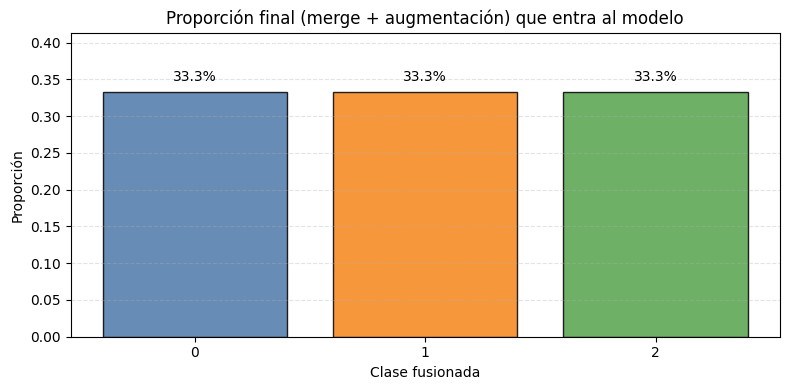

In [13]:
# Distribución final que entra al modelo (después de merge + augmentación en minoritarias)
fig, ax = plt.subplots(figsize=(8, 4))

bars = ax.bar(
    train_proportions_after_aug.index.astype(str),
    train_proportions_after_aug.values,
    color=["#4C78A8", "#F58518", "#54A24B"],
    edgecolor="black",
    alpha=0.85,
)

for bar, prop in zip(bars, train_proportions_after_aug.values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{prop * 100:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

ax.set_title("Proporción final (merge + augmentación) que entra al modelo")
ax.set_xlabel("Clase fusionada")
ax.set_ylabel("Proporción")
ax.set_ylim(0, min(1.0, float(train_proportions_after_aug.max()) + 0.08))
ax.grid(axis="y", linestyle="--", alpha=0.35)

plt.tight_layout()
plt.show()

In [14]:
# 3) Extraer features con DenseNet (usa CUDA si está disponible).
FEATURE_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo para extracción de features (baseline): {FEATURE_DEVICE}")

if FEATURE_DEVICE.type == "cuda":
    # Recomendado para GPUs con Tensor Cores.
    torch.set_float32_matmul_precision("high")

feature_model = build_densenet121_feature_extractor()

X_train, y_train = extract_baseline_features(feature_model, train_loader, FEATURE_DEVICE)
X_val, y_val = extract_baseline_features(feature_model, val_loader, FEATURE_DEVICE)

print(f"Labels train: {sorted(np.unique(y_train).tolist())}")
print(f"Labels val  : {sorted(np.unique(y_val).tolist())}")

Dispositivo para extracción de features (baseline): cuda


Extrayendo features (DenseNet):   0%|          | 0/323 [00:00<?, ?it/s]

Feature matrix shape: (10332, 1046)


Extrayendo features (DenseNet):   0%|          | 0/98 [00:00<?, ?it/s]

Feature matrix shape: (3133, 1046)
Labels train: [0, 1, 2]
Labels val  : [0, 1, 2]


### Desempeño mínimo esperado

Como referencia mínima, calculamos un predictor ingenuo que siempre predice la clase mayoritaria del entrenamiento.  
El baseline propuesto debe superar esta referencia para considerar que está aprendiendo señal útil.

In [15]:

majority_class = Counter(y_train).most_common(1)[0][0]
y_val_pred_naive = np.full(shape=len(y_val), fill_value=majority_class)

naive_f1_macro = f1_score(y_val, y_val_pred_naive, average="macro", zero_division=0)
naive_acc = accuracy_score(y_val, y_val_pred_naive)

print("Baseline ingenuo (clase mayoritaria)")
print(f"Clase mayoritaria: {majority_class}")
print(f"Validación macro-F1: {naive_f1_macro:.4f}")
print(f"Validación accuracy: {naive_acc:.4f}")

Baseline ingenuo (clase mayoritaria)
Clase mayoritaria: 2
Validación macro-F1: 0.0561
Validación accuracy: 0.0919


### Búsqueda de hiperparámetros (RandomizedSearchCV) para XGBoost

En esta etapa buscamos definir un baseline de XGBoost con hiperparámetros seleccionados de forma reproducible y con cómputo limitado, evitando elegir valores “a ojo”.

#### ¿Qué hace RandomizedSearchCV?
- Toma un conjunto acotado de rangos de hiperparámetros (por ejemplo: `max_depth`, `n_estimators`, `learning_rate`, etc.).
- Prueba `n_iter` configuraciones aleatorias distintas dentro de esos rangos.
- Para cada configuración, evalúa el desempeño usando validación cruzada con 3 folds.
- Con esto, el total de entrenamientos durante la búsqueda es: `n_iter × 3`.
- Al final, reentrena automáticamente el mejor modelo encontrado usando todo el conjunto de entrenamiento (esto ocurre porque `refit=True`).

#### Métrica objetivo
Se optimiza F1-macro (`f1_macro`) porque conviene medir el desempeño de forma pareja entre clases, especialmente cuando hay desbalance. En este tipo de problema, la exactitud (accuracy) puede verse alta aunque el modelo falle en clases menos frecuentes, por eso F1-macro es una referencia más útil para la toma de decisiones.

#### Control de cómputo
Para respetar el cómputo disponible:
- La búsqueda se limita a pocas iteraciones (`n_iter` pequeño).
- Se utiliza una validación cruzada compacta (`cv=3`).
- Se usa `tree_method="hist"` para acelerar el entrenamiento en CPU.

El resultado de esta sección es un modelo baseline (`best_model`) y una configuración explícita (`best_params`) que se reporta como parte del entregable.

### Justificación corta de cada hiperparámetro (rangos candidatos)

- **`n_estimators (150-320)`**: número de árboles. Más árboles = más capacidad, pero más costo. El rango permite encontrar un buen balance sin disparar el tiempo.

- **`max_depth (3-6)`**: qué tan “profundos” son los árboles. Profundidades bajas suelen generalizar mejor; el rango evita árboles demasiado complejos.

- **`learning_rate (0.02-0.18)`**: qué tan rápido aprende. Tasas bajas suelen ser más estables; el rango cubre valores comunes sin volverlo agresivo.

- **`subsample (0.7-0.3)`**: porcentaje de datos por árbol. Menor a 1 introduce aleatoriedad y reduce overfitting; no bajamos demasiado para no perder señal.

- **`colsample_bytree (0.7-0.3)`**: porcentaje de features por árbol. Ayuda a que el modelo no dependa de pocas dimensiones del embedding.

- **`min_child_weight (1-7)`**: qué tan “difícil” es crear hojas nuevas. Valores altos hacen el modelo más conservador y ayudan con ruido/desbalance.

- **`gamma (0.0-0.4)`**: penalización para permitir splits. Subirlo reduce splits innecesarios y controla overfitting.

- **`reg_alpha (0.0-0.6)`**: regularización L1. Puede “apagar” features poco útiles y ayudar cuando hay muchas dimensiones.

- **`reg_lambda (0.8-1.7)`**: regularización L2. Estabiliza el modelo y reduce sensibilidad al ruido; rango alrededor de valores típicos.

In [16]:
# RandomizedSearchCV — search space (compute-limited)
param_distributions = {
    "n_estimators": randint(120, 320),
    "max_depth": randint(3, 6),
    "learning_rate": uniform(0.02, 0.18),
    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3),
    "min_child_weight": randint(1, 7),
    "gamma": uniform(0.0, 0.4),
    "reg_alpha": uniform(0.0, 0.6),
    "reg_lambda": uniform(0.8, 1.7),
}

In [17]:
# XGBoost estimator + CV + scorer
xgb_device = "cuda"
xgb_gpu_jobs = 2
print(f"XGBoost device: {xgb_device}")

unique_labels = np.unique(y_train)
is_binary = len(unique_labels) == 2
xgb_objective = "binary:logistic" if is_binary else "multi:softprob"
xgb_eval_metric = "logloss" if is_binary else "mlogloss"

xgb_base_kwargs = {
    "objective": xgb_objective,
    "eval_metric": xgb_eval_metric,
    "tree_method": "hist",
    "device": xgb_device,
    "max_bin": 256,
    "random_state": 42,
    "n_jobs": xgb_gpu_jobs,
}
if not is_binary:
    xgb_base_kwargs["num_class"] = int(len(unique_labels))

xgb_base = XGBClassifier(**xgb_base_kwargs)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = make_scorer(f1_score, average="macro")

XGBoost device: cuda


In [18]:
# Run RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=12,
    scoring=scoring,
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=1,
    refit=True,
)

print("Starting RandomizedSearchCV training...")
search.fit(X_train, y_train)


Starting RandomizedSearchCV training...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/home/anaya/Development/Robomous/sam-ai/.venv/lib/python3.12/site-packages/xgboost/core.py:751: UserWarning: [03:19:46] WARNING: /__w/xgboost/xgboost/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBClassifier..._class=3, ...)"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'colsample_bytree': <scipy.stats....x7d6c887ea300>, 'gamma': <scipy.stats....x7d6c887eb2c0>, 'learning_rate': <scipy.stats....x7d6c887e9250>, 'max_depth': <scipy.stats....x7d6c97f34fb0>, ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",12
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",make_scorer(f...average=macro)
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :

In [19]:
best_model = search.best_estimator_
best_params = search.best_params_
best_cv_score = search.best_score_

print("Parametros:")
print("n_estimators: ", best_params["n_estimators"])
print("max_depth: ", best_params["max_depth"])
print("learning_rate: ", best_params["learning_rate"])
print("subsample: ", best_params["subsample"])
print("colsample_bytree: ", best_params["colsample_bytree"])
print("min_child_weight: ", best_params["min_child_weight"])
print("gamma: ", best_params["gamma"])
print(f"Best CV F1-macro: {best_cv_score:.4f}")

Parametros:
n_estimators:  200
max_depth:  5
learning_rate:  0.16997508411250956
subsample:  0.7935133228268232
colsample_bytree:  0.9049790556476374
min_child_weight:  6
gamma:  0.24399866311304838
Best CV F1-macro: 0.8227


### Evaluación del modelo ajustado

Aquí se reportan `best_params` y `best_cv_score` de la búsqueda aleatoria, pero la interpretación se hace sobre el contexto de datos ya documentado:

- se entrena con clases fusionadas en 3 niveles de severidad,
- se usa un train balanceado verificable (`final_train_counts`),
- y la validación mantiene distribución natural para medir generalización.

Se usa **f1_macro** como referencia principal porque evita que una clase dominante oculte errores de clases menos frecuentes. Accuracy se mantiene como métrica complementaria.

La lectura de resultados se hace en este orden:
1. desempeño agregado (`macro-F1`),
2. desempeño por clase (`classification_report`),
3. patrón de error (`confusion_matrix`).

Esto permite justificar no solo si el modelo mejora, sino también **por qué** mejora o dónde todavía falla.

In [20]:
# 5) Validation evaluation: tuned baseline (best_model from RandomizedSearchCV).
y_val_pred = best_model.predict(X_val)

val_f1_macro = f1_score(y_val, y_val_pred, average="macro", zero_division=0)

print("Validation macro-F1 (tuned baseline)")
print(f"Macro-F1: {val_f1_macro:.4f}")

print("Tuned baseline (validation) — classification report")
print(classification_report(y_val, y_val_pred, digits=4, zero_division=0))

final_model = best_model
y_pred = y_val_pred

Validation macro-F1 (tuned baseline)
Macro-F1: 0.7579
Tuned baseline (validation) — classification report
              precision    recall  f1-score   support

           0     0.8447    0.8641    0.8543      1567
           1     0.7676    0.7261    0.7463      1278
           2     0.6386    0.7118    0.6732       288

    accuracy                         0.7938      3133
   macro avg     0.7503    0.7673    0.7579      3133
weighted avg     0.7943    0.7938    0.7936      3133



### Señal de generalización

Además de reportar métricas en validación, comparamos el desempeño en entrenamiento contra validación para medir la brecha de generalización.  
Si el entrenamiento es muy superior a la validación, el modelo está aprendiendo patrones demasiado específicos del train y su desempeño fuera de muestra se reduce.

In [21]:
y_train_pred = final_model.predict(X_train)

train_f1_macro = f1_score(y_train, y_train_pred, average="macro", zero_division=0)
val_f1_macro = f1_score(y_val, y_pred, average="macro", zero_division=0)

print("Comparación de generalización (macro-F1)")
print(f"Entrenamiento macro-F1: {train_f1_macro:.4f}")
print(f"Validación   macro-F1: {val_f1_macro:.4f}")
print(f"Brecha (train - val): {(train_f1_macro - val_f1_macro):.4f}")

Comparación de generalización (macro-F1)
Entrenamiento macro-F1: 1.0000
Validación   macro-F1: 0.7579
Brecha (train - val): 0.2421


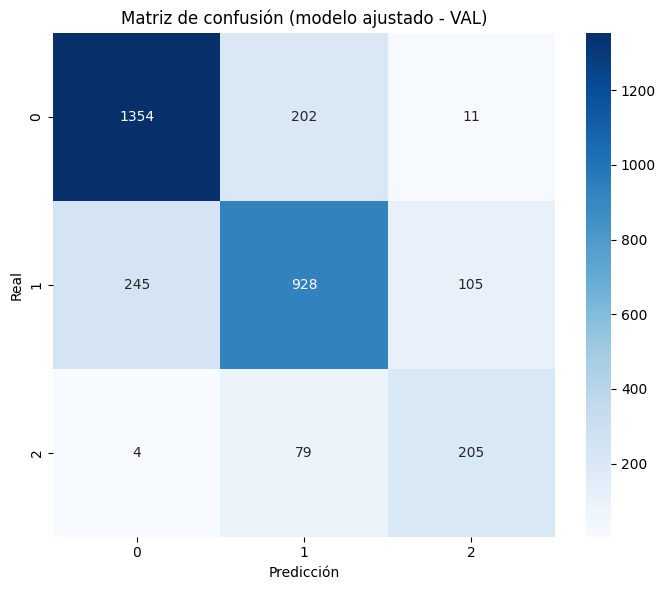

In [22]:
# 6) Confusion matrix (tuned model on VAL).
labels_sorted = sorted(int(x) for x in np.unique(y_val))
cm = confusion_matrix(y_val, y_pred, labels=labels_sorted)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels_sorted,
    yticklabels=labels_sorted,
)
plt.title("Matriz de confusión (modelo ajustado - VAL)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

### Importancia de características

En este baseline, las características corresponden a las dimensiones del embedding generado por DenseNet-121.  
XGBoost permite estimar qué dimensiones aportan más a la decisión. Esto ayuda a interpretar el modelo y a detectar si el clasificador depende demasiado de pocas señales.

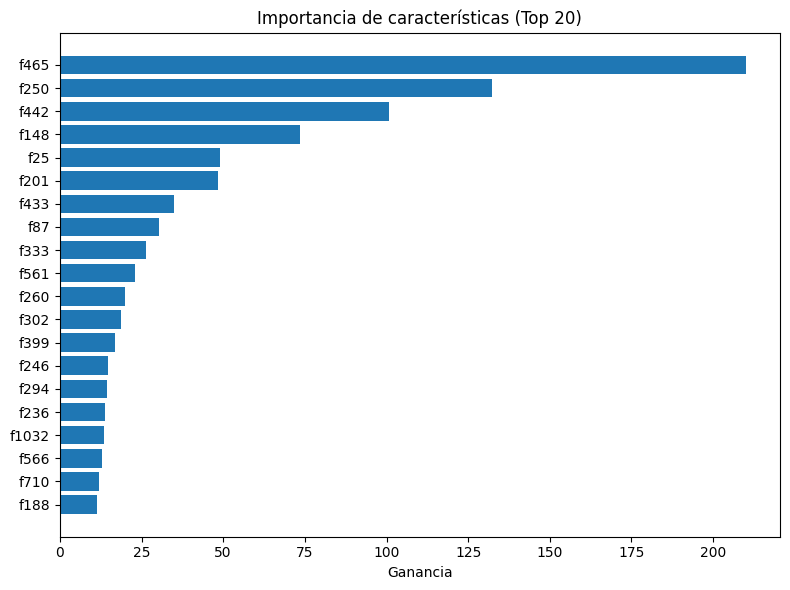

Top características por ganancia:


,feature,gain
0,f465,209.964966
1,f250,132.256607
2,f442,100.716064
3,f148,73.557930
4,f25,48.908203
5,f201,48.543465
6,f433,34.938854
7,f87,30.473259
8,f333,26.436287
9,f561,22.899595


In [23]:
# Importancia de las características (XGBoost): características principales por ganancia
booster = final_model.get_booster()
score = booster.get_score(importance_type="gain")

importance_df = (
    pd.DataFrame({"feature": list(score.keys()), "gain": list(score.values())})
    .sort_values("gain", ascending=False)
    .reset_index(drop=True)
)

top_k = 20
top_df = importance_df.head(top_k)

plt.figure(figsize=(8, 6))
plt.barh(top_df["feature"][::-1], top_df["gain"][::-1])
plt.xlabel("Ganancia")
plt.title(f"Importancia de características (Top {top_k})")
plt.tight_layout()
plt.show()

print("Top características por ganancia:")
display(top_df)

### Interpretación de la importancia de características

La gráfica muestra que la ganancia (gain) se concentra en un conjunto reducido de dimensiones del embedding (por ejemplo f465, f250 y f442 destacan con valores mucho mayores que el resto). Esto sugiere que, dentro de la representación generada por DenseNet-121, el clasificador está encontrando señal discriminativa fuerte en pocas componentes.

Esto es útil por dos razones:

- Permite validar que el modelo no está usando “ruido” de manera uniforme, sino que identifica señales dominantes.
- También indica un posible riesgo: si el desempeño depende demasiado de pocas dimensiones, el modelo puede volverse sensible a variaciones del dataset o a cambios sutiles de preprocesamiento.

En las siguientes iteraciones, este análisis se puede usar para revisar estabilidad y para experimentar con regularización o reducción de dimensionalidad, si se observa una concentración excesiva.

## 11) Conclusiones y respuesta a las preguntas de la fase

### ¿Qué algoritmo usamos como baseline?
El baseline que se documenta en este notebook es: DenseNet-121 como extractor de características + XGBoost como clasificador. Este enfoque es práctico porque aprovecha una representación visual robusta (DenseNet) y permite entrenar un clasificador eficiente (XGBoost) con resultados reproducibles en cómputo limitado.

### ¿Qué decisiones de datos se tomaron y por qué?
Se hicieron ajustes deliberados al dataset para que el entrenamiento sea más estable y la evaluación sea más clara:

- Se redujo el problema de 5 a 3 clases agrupando severidades cercanas (`0, 1+2, 3+4`) para disminuir ambigüedad entre grados adyacentes.
- Se aplicó CLAHE de forma consistente en entrenamiento y validación para evitar cambios de distribución por preprocesamiento.
- Se construyó un conjunto de entrenamiento con balance controlado usando un `target_count_per_class` verificable (con conteos finales impresos).
- La validación se mantuvo con distribución natural para observar el comportamiento del modelo en un escenario más realista.

Estas decisiones impactan directamente lo que aprende el modelo y evitan comparar resultados sobre distribuciones intermedias.

### ¿Qué aportó la búsqueda de hiperparámetros?
Se utilizó RandomizedSearchCV con una búsqueda acotada (12 configuraciones, validación cruzada de 3 folds) para seleccionar hiperparámetros de forma justificable y reproducible.

- Mejor resultado en validación cruzada (macro-F1): `0.8227`
- Resultado en validación (macro-F1): `0.7579`

La diferencia entre CV y validación sugiere que aún hay espacio para mejorar generalización (por ejemplo, por desbalance residual, ruido entre clases agrupadas o variación entre particiones).

Además, la comparación entrenamiento vs validación muestra una brecha de generalización.  
Esto sugiere sobreajuste del clasificador respecto al conjunto de entrenamiento, por lo que el desempeño en validación es la referencia principal para interpretar viabilidad y siguientes ajustes.

### ¿Podemos determinar importancia de características?
Sí. XGBoost permite analizar importancia de características sobre el embedding, lo cual ayuda a revisar qué señales del vector están influyendo más en la decisión y a detectar si el modelo depende demasiado de pocas dimensiones.

### ¿Qué métrica es adecuada para el negocio?
Para este caso conviene priorizar macro-F1 y macro-recall porque reflejan el desempeño de forma más pareja entre clases, especialmente cuando hay desbalance. Accuracy se mantiene como referencia secundaria.

### ¿Cuál debe ser el desempeño mínimo?
El desempeño mínimo esperado es superar un predictor ingenuo que siempre predice la clase mayoritaria. Si el modelo no supera ese punto de referencia, lo más probable es que haya que revisar la señal del dataset o la consistencia del pipeline antes de incrementar complejidad.

En este notebook se calculó el baseline ingenuo (predecir siempre la clase mayoritaria) y se comparó contra el modelo final.  
El macro-F1 del modelo en validación supera al macro-F1 del baseline ingenuo, por lo que el enfoque aporta valor por encima de lo mínimo esperado.

### Cierre
La distribución reportada en esta sección corresponde al dataset final que entra al modelo. Con esto, el baseline queda establecido como referencia para iteraciones posteriores, y los resultados actuales se consideran una primera medición razonable de viabilidad con cómputo limitado.

### Notas adicionales
Se utilizaron asistentes de IA generativa para ayudarnos a convertir los enfoques propuestos de forma teorica y conectual en la literatura revisada, en modelos de codigo (PyTorch + Scikit-learn) reproducibles en nuestro entorno. Esto siempre verificando los resultados obtenidos y prosiguiendo a hacer ajustes manuales hasta poder integrar el codigo al proyecto.

Referencias:

- Huang, G., Liu, Z., Van Der Maaten, L., & Weinberger, K. Q. (2017). Densely connected convolutional networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4700-4708).
- Kumar, V., Sharma, G., & Garg, D. (2023, November). Analysis of Early Detection and Prediction of Diabetic Retinopathy by Optimize Deep Learning with XG-Boosting. In Conference on Smart Generation Computing and Communication Networks (pp. 61-69). Cham: Springer Nature Switzerland.
- Nahiduzzaman, M., Islam, M. R., Goni, M. O. F., Anower, M. S., Ahsan, M., Haider, J., & Kowalski, M. (2023). Diabetic retinopathy identification using parallel convolutional neural network based feature extractor and ELM classifier. Expert Systems with Applications, 217, 119557.
- Nneji, G. U., Cai, J., Deng, J., Monday, H. N., Hossin, M. A., & Nahar, S. (2022). Identification of diabetic retinopathy using weighted fusion deep learning based on dual-channel fundus scans. Diagnostics, 12(2), 540.
- Meenakshi, K., Kishore, D., & Srinivasa Rao, C. (2024, October). Enhanced Detection of Diabetic Retinopathy Through Transfer Learning with DenseNet-121 and XGBoost Classifier. In International Conference on Computer & Communication Technologies (pp. 409-419). Singapore: Springer Nature Singapore.
- Visengeriyeva, L., Kammer, A., Bär, I., Kniesz, A., y Plöd, M. (2023). CRISP-ML(Q). The ML Lifecycle Process. MLOps. INNOQ.